In [2]:
# Get data from:
# https://files.catbox.moe/1cypdf.zip
# https://files.catbox.moe/bzbcdw.zip

# STL files:
# https://files.catbox.moe/mply23.zip
# https://files.catbox.moe/3glm31.ipynb

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import cv2
from torchsummary import summary

# Set the paths to the image folders
pre_optimization_folder = './256x256/preProjectionSeq/'
post_optimization_folder = './256x256/ImageSeq/'

# Function to load grayscale images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

# Load pre-optimization grayscale images
pre_optimization_images = load_images_from_folder(pre_optimization_folder)

# Load post-optimization grayscale images
post_optimization_images = load_images_from_folder(post_optimization_folder)

# Convert image lists to numpy arrays
pre_optimization_images = np.array(pre_optimization_images)
post_optimization_images = np.array(post_optimization_images)

# Normalize the image data
pre_optimization_images = pre_optimization_images / 255.0
post_optimization_images = post_optimization_images / 255.0

# Convert numpy arrays to PyTorch tensors
x_train = torch.from_numpy(pre_optimization_images).unsqueeze(1).float()
y_train = torch.from_numpy(post_optimization_images).unsqueeze(1).float()


print("First pre-optimization image:")
plt.imshow(pre_optimization_images[0], cmap='gray')
plt.show()

print("First post-optimization image:")
plt.imshow(post_optimization_images[0], cmap='gray')
plt.show()



In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.middle_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        )

        self.decoder = nn.Sequential(
            
            nn.Conv2d(192, 64, kernel_size=3, padding=1),  # Concatenating feature maps from the encoder
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        encoder_output1 = self.encoder(x)
        encoder_output2 = self.middle_conv(encoder_output1)
        decoder_input = torch.cat([encoder_output2, encoder_output1], dim=1)  # Concatenate feature maps
        decoder_output = self.decoder(decoder_input)
        return decoder_output

# Create an instance of the UNet model
model = UNet()


Available GPUs:
GPU 0: NVIDIA RTX A5000
PyTorch is using GPU.

Best validation loss: 0.0013091982557619634
Epoch [1/200], Train Loss: 0.0031, Val Loss: 0.0013

Best validation loss: 0.0011540181930712631
Epoch [2/200], Train Loss: 0.0013, Val Loss: 0.0012
Epoch [3/200], Train Loss: 0.0012, Val Loss: 0.0012

Best validation loss: 0.0010152138559460903
Epoch [4/200], Train Loss: 0.0011, Val Loss: 0.0010
Epoch [5/200], Train Loss: 0.0011, Val Loss: 0.0011

Best validation loss: 0.0009637709173365637
Epoch [6/200], Train Loss: 0.0011, Val Loss: 0.0010

Best validation loss: 0.0009561766856411818
Epoch [7/200], Train Loss: 0.0010, Val Loss: 0.0010

Best validation loss: 0.0009170483882266995
Epoch [8/200], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [9/200], Train Loss: 0.0010, Val Loss: 0.0009

Best validation loss: 0.0008935313929383338
Epoch [10/200], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [11/200], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [12/200], Train Loss: 0.0010, Val Loss: 0.0

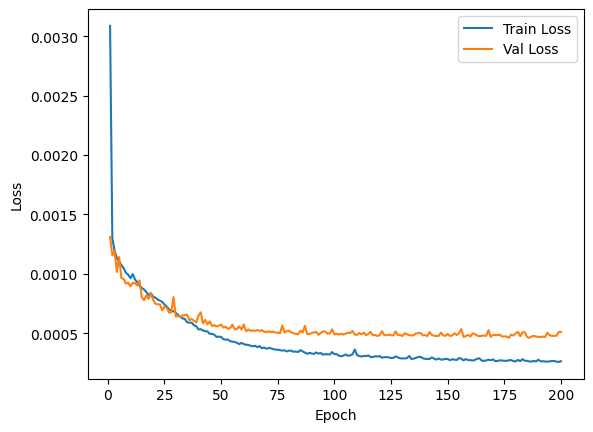

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

device_count = torch.cuda.device_count()
if device_count > 0:
    print("Available GPUs:")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available. PyTorch is using CPU.")

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the UNet model
model = UNet()

if torch.cuda.is_available():
    model = model.to(device)
    print("PyTorch is using GPU.")
else:
    print("PyTorch is using CPU.")

# Convert the data to the appropriate device
x_train = x_train.to(device)
y_train = y_train.to(device)

# Divide the dataset into training and validation sets
dataset = TensorDataset(x_train, y_train)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create PyTorch DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 200
train_losses = []
val_losses = []
bestVal_loss = float('inf')

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate the average loss for training set
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    if (val_loss < bestVal_loss):
        bestVal_loss = val_loss
        print(f"\nBest validation loss: {bestVal_loss}")
        torch.save(model.state_dict(), 'model.pth')
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot the training and validation losses and lowest validation loss
print(f"\nBest validation loss: {bestVal_loss}")
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
# torch.save(model.state_dict(), "model.pth")


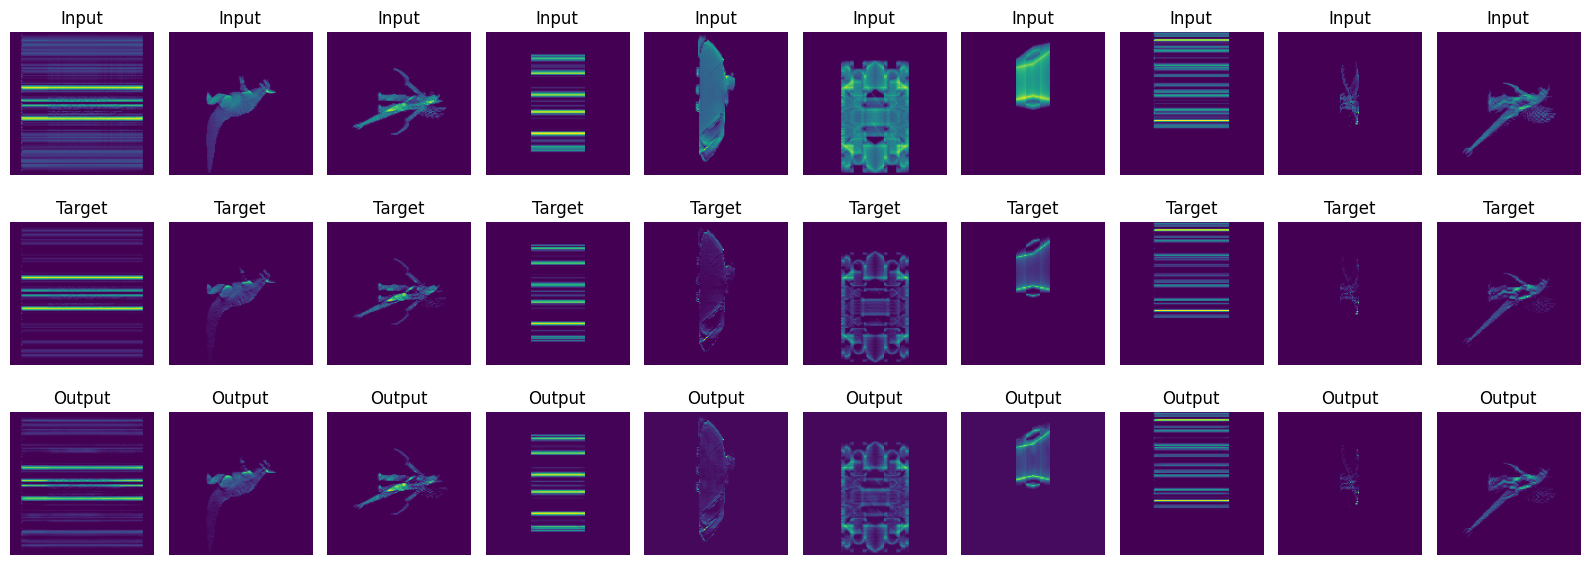

In [ ]:
import matplotlib.pyplot as plt

# Display 10 example inputs and outputs from the validation dataset
model.eval()  # Set the model to evaluation mode

# Get a batch from the validation dataloader
example_inputs, example_targets = next(iter(val_dataloader))
example_inputs = example_inputs.to(device)
example_targets = example_targets.to(device)

# Forward pass through the model
with torch.no_grad():
    example_outputs = model(example_inputs)

# Convert the tensors to numpy arrays
example_inputs = example_inputs.cpu().numpy()
example_targets = example_targets.cpu().numpy()
example_outputs = example_outputs.cpu().numpy()

# Reshape the example inputs, targets, and outputs if needed
# (Assuming the inputs and outputs have shape (batch_size, channels, height, width))
example_inputs = example_inputs.transpose(0, 2, 3, 1)
example_targets = example_targets.transpose(0, 2, 3, 1)
example_outputs = example_outputs.transpose(0, 2, 3, 1)

# Plot the example inputs, targets, and outputs
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(example_inputs[i])
    plt.title('Input')
    plt.axis('off')

    plt.subplot(3, 10, 10 + i + 1)
    plt.imshow(example_targets[i])
    plt.title('Target')
    plt.axis('off')

    plt.subplot(3, 10, 20 + i + 1)
    plt.imshow(example_outputs[i])
    plt.title('Output')
    plt.axis('off')

plt.tight_layout()
plt.show()


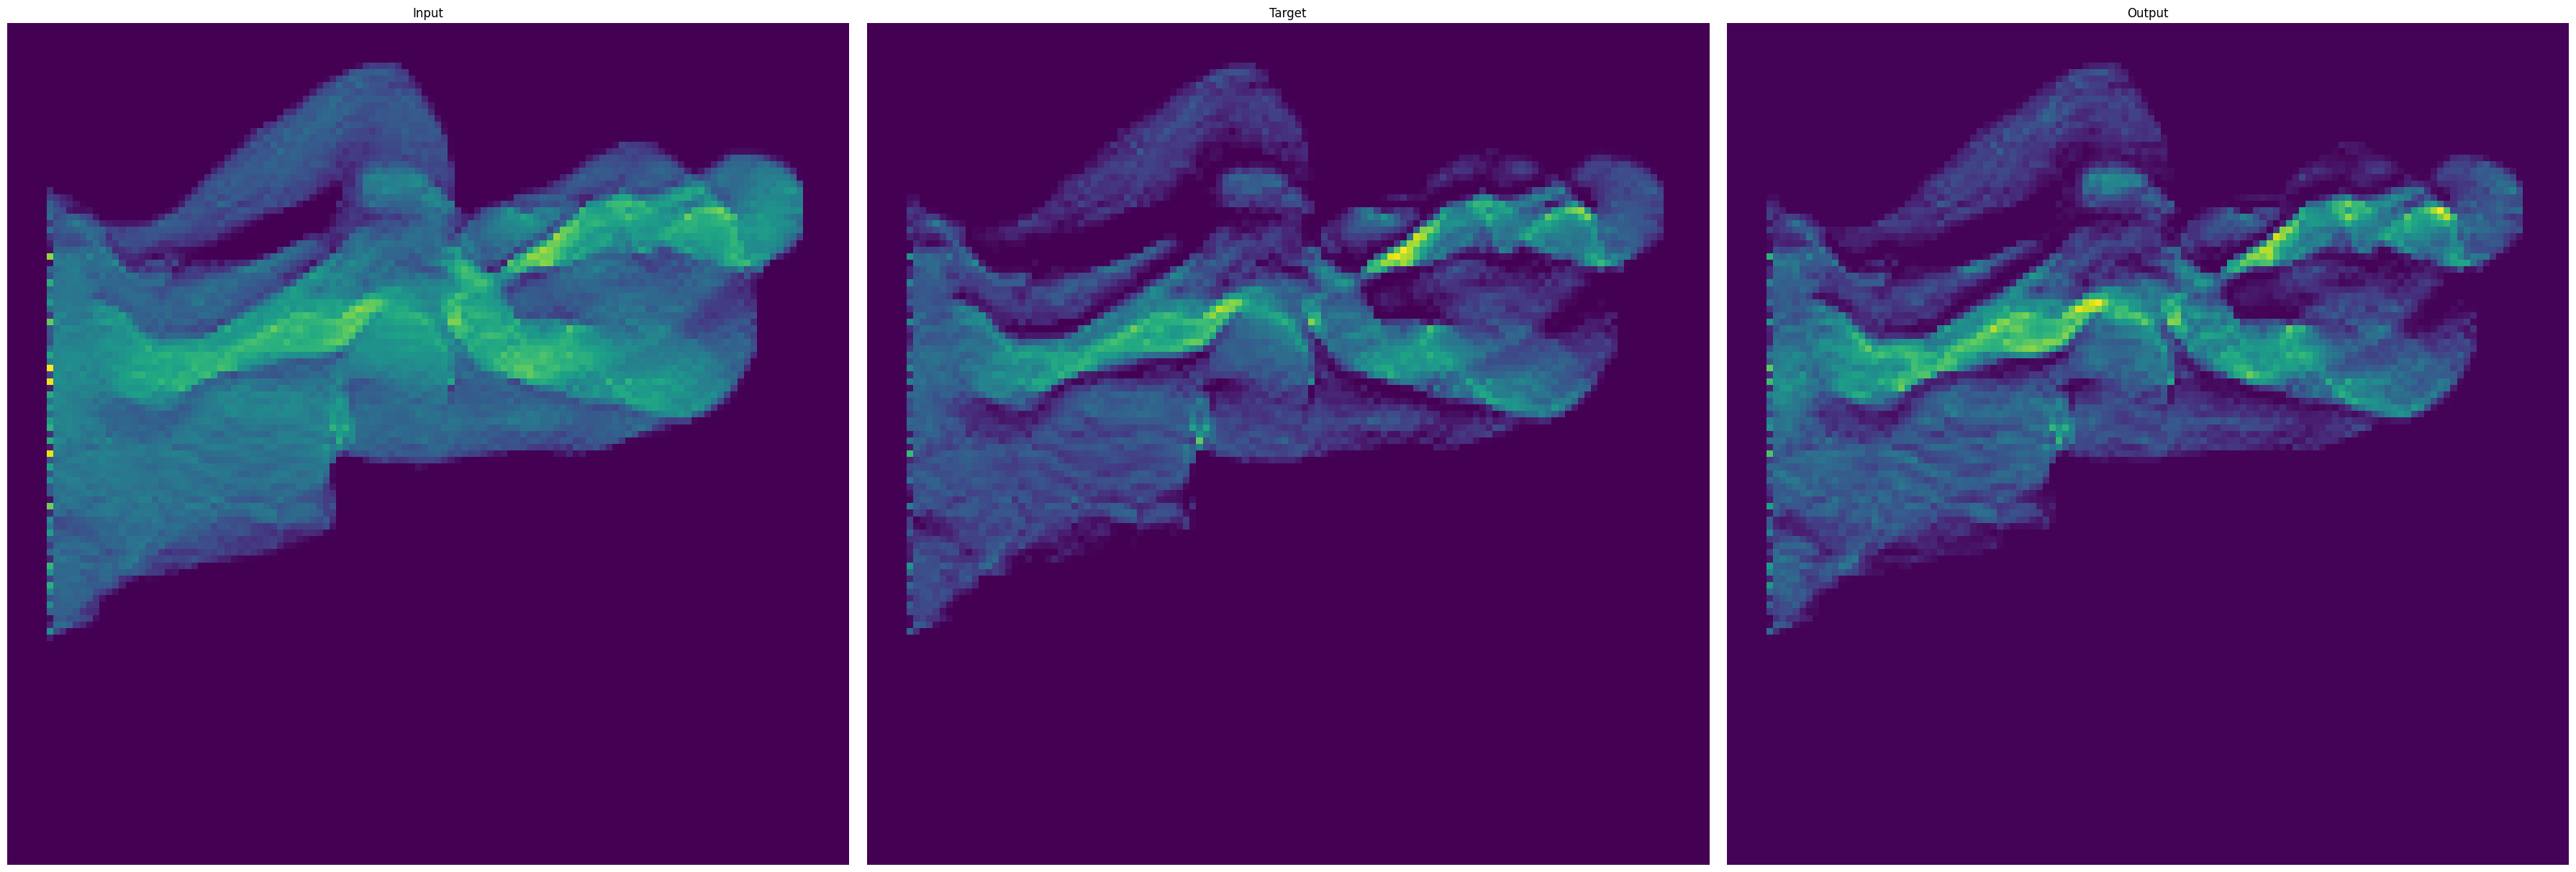

In [ ]:

# Get a batch from the validation dataloader
example_inputs, example_targets = next(iter(val_dataloader))
example_inputs = example_inputs.to(device)
example_targets = example_targets.to(device)

# Choose a specific example from the batch
example_index = 23

# Forward pass through the model
with torch.no_grad():
    example_output = model(example_inputs[example_index].unsqueeze(0))

# Convert the tensors to numpy arrays
example_input = example_inputs[example_index].cpu().numpy().transpose(1, 2, 0)
example_target = example_targets[example_index].cpu().numpy().transpose(1, 2, 0)
example_output = example_output[0].cpu().numpy().transpose(1, 2, 0)

# Plot the example input, target, and output side by side
plt.figure(figsize=(36, 12))

# Plot the example input
plt.subplot(1, 3, 1)
plt.imshow(example_input)
plt.title('Input')
plt.axis('off')

# Plot the example target
plt.subplot(1, 3, 2)
plt.imshow(example_target)
plt.title('Target')
plt.axis('off')

# Plot the example output
plt.subplot(1, 3, 3)
plt.imshow(example_output)
plt.title('Output')
plt.axis('off')

plt.tight_layout()
plt.show()
